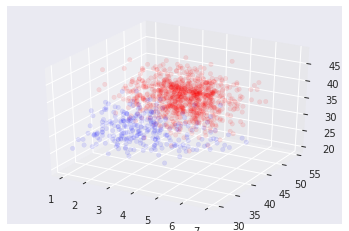

In [1]:
import warnings
warnings.filterwarnings('ignore')
import theano
theano.config.floatX = 'float64'
import theano.tensor as t
from theano.tensor.nlinalg import det

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
from pymc3.math import logsumexp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import scipy as sp
import numpy as np

import seaborn as sns
%matplotlib inline
df_train = pd.read_csv('birth_data_train_n.csv')
df_train.head()
prem = lambda x: 0. if x / 7. > 36. else 1.
df_train.loc[:, 'gestation age'] = df_train['gestation age'].apply(prem)

prem_df = df_train[df_train['gestation age'] == 1]
reg_df = df_train[df_train['gestation age'] == 0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(prem_df['weight'].values, prem_df['length'].values, prem_df['head circumference'].values, color='b', alpha=0.1)
ax.scatter(reg_df['weight'].values, reg_df['length'].values, reg_df['head circumference'].values, color='r', alpha=0.1)
plt.show()

In [2]:
#covariates
train_cov = df_train[['mothers age', 'mothers income', 'mothers years of post-2nd edu']].values
covariates = t._shared(train_cov)

#training data
train_x = df_train[['weight', 'length', 'head circumference']].values
train_y = df_train['gestation age'].values
x_obs = t._shared(train_x)
n_samples = len(train_x)
dim = train_x.shape[1]

In [3]:
# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * t.log(2 * np.pi) + t.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau0, tau1):
    def logp_(value):
        logps = [t.log(pi[0]) + logp_normal(mus[0], tau0, value), 
                 t.log(pi[1]) + logp_normal(mus[1], tau1, value)]

        return t.sum(logsumexp(t.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

# define invlogit function
def invlogit(x):
    return t.exp(x) / (1 + t.exp(x))

with pm.Model() as model_2:
    
    sigma0 = pm.Uniform('sigma0', 0, 20, shape=dim)
    sigma1 = pm.Uniform('sigma1', 0, 20, shape=dim)
    
  
    sigma_diag0 = pm.Deterministic('cov0', t.nlinalg.diag(sigma0))
    tau0 = pm.Deterministic('tau0', t.nlinalg.matrix_inverse(sigma_diag0))
    
    sigma_diag1 = pm.Deterministic('cov1', t.nlinalg.diag(sigma1))
    tau1 = pm.Deterministic('tau1', t.nlinalg.matrix_inverse(sigma_diag1))
    
    
    mus = t.stack([MvNormal('mu_%d' % i, mu=np.zeros(3) + 5., tau=0.01 * np.eye(3), shape=(3,))
           for i in range(2)])
    
    alpha = pm.Normal('alpha', mu=0, tau=1 / 10)
    beta = pm.Normal('beta', mu=0, tau=1 / 10, shape=(3,))
    
    pi1 = pm.Deterministic('p', invlogit(alpha + beta.dot(covariates.T)))
    pi = t.stack([pi1, 1-pi1])
    
    xs = DensityDist('x', logp_gmix(mus, pi, tau0, tau1), observed=x_obs)

In [9]:
with model_2:
    step = pm.Metropolis()
    trace = sample(100000, step=step)

100%|██████████| 100000/100000 [05:44<00:00, 290.66it/s]


In [10]:
pm.stats.waic(trace[10000::10], model_2)

(17137.8561068567, 0.0)

In [13]:
alpha = trace['alpha'][10000::10].mean()
beta = trace['beta'][10000::10].mean(axis=0)

In [14]:
alpha

0.028414079285706918

In [15]:
beta

array([ 0.03418605, -2.55057491,  0.00297427])